# Thinking about movies and words in high-dimensional space

As chapter 6 of Jurafsky and Martin explained, both the columns and the rows of a term-document matrix can be understood geometrically as points in space. (Or, if you prefer, as *vectors* drawn from the origin of a coordinate system to a particular point.)

![A term-doc matrix and vector representation of same](jurafskyvector.png)

To make visualization easier, the textbook has chosen two dimensions here. But the space defined by the term-document matrix really has four dimensions. We can't easily draw a picture of four-dimensional space, but it's perfectly possible to measure distance there.

See section 6.4 of Jurafsky and Martin for a mathematical explanation of "cosine similarity." The cosine ranges from -1 to 1, and is largest when two vectors are very *similar.* (As you can see below, the cosine gets smaller as the angle X gets larger.)

![https://www.quora.com/Mathematics-Why-does-the-obtuse-angle-of-cos-x-give-a-negative-value](cosine.png)

To convert it into something more like a distance, it's conventional to measure

1 - cos(X)

which can be called "cosine distance."

In this notebook, we'll explore ways to reason geometrically about cultural objects by treating them as points in high-dimensional space. The examples we'll use are movies and movie characters, but much of this logic will apply also to images.

We will

1. Compare features (words) and instances (movies) by measuring the cosine distance between them,

2. Cluster movie scripts in semantic space, and

3. Flatten high-dimensional space into a plane, using a variety of *dimension reduction* techniques. Some information will be lost when we do this, but it's still a useful way to explore complex data.

### Import useful modules and read data

We'll be using the same dialogue data we used in HW3.

In [13]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from pathlib import Path
import seaborn as sns
import math, re, random
from scipy.spatial.distance import cosine
from collections import Counter
from ast import literal_eval
from sklearn.preprocessing import StandardScaler

We start by reading in the familiar dataframe, with one row per character.

In [2]:
dialogpath = Path('../../data/movie_dialogue.tsv')

chars = pd.read_csv(dialogpath, sep = '\t')

chars.head()

,mid,cid,cname,mname,gender,wordcount,year,genres,comedy,thriller,drama,romance,lines
0,m0,u0,BIANCA,10 things i hate about you,f,959,1999,"['comedy', 'romance']",True,False,False,True,They do not! / I hope so. / Let's go. / Okay -...
1,m0,u2,CAMERON,10 things i hate about you,m,527,1999,"['comedy', 'romance']",True,False,False,True,"They do to! / She okay? / Wow / No / The ""real..."
2,m0,u4,JOEY,10 things i hate about you,m,278,1999,"['comedy', 'romance']",True,False,False,True,"Listen, I want to talk to you about the prom. ..."
3,m0,u5,KAT,10 things i hate about you,f,1217,1999,"['comedy', 'romance']",True,False,False,True,Perm? / It's just you. / What? To completely d...
4,m0,u6,MANDELLA,10 things i hate about you,f,157,1999,"['comedy', 'romance']",True,False,False,True,William - he asked me to meet him here. / Have...


### Aggregate dialogue at the movie level

But for this problem, it's more manageable (at least initially) to talk about movies rather than characters. So let's aggregate the dialogue at the movie level.

```.groupby()``` helps with this, but it's still not a totally straightforward task. It's hard to avoid writing a loop.

In [3]:
# A simple-to-understand, if clunky, way to group by movie
# We start by creating a dictionary with column labels as 
# the keys; each value will be a list that turns into a
# column in a new dataframe with one row per movie.

movie_dict = dict()
exclude = {'cid', 'cname', 'gender'}  # movies don't have these

for col in chars.columns:
    if not col in exclude:
        movie_dict[col] = []    # initialize the list
        
movie_dict['action'] = []   # we're also going to add a column for action films

for movie_id, df in chars.groupby('mid'):
    
    dialogue = ' '.join([x for x in df['lines']])  #
    movie_dict['lines'].append(dialogue)
    
    for col in chars.columns:
        if col in exclude or col == 'lines' or col == 'wordcount':
            continue
        else:
            movie_dict[col].append(df[col].values[0]) # for most columns all rows
                                                # of the grouped df are the same
                                                # so just take the first entry
    
    movie_dict['wordcount'].append(np.sum(df['wordcount']))  # sum
    
    if 'action' in df['genres'].values[0]:
        actionval = True
    else:
        actionval = False
    movie_dict['action'].append(actionval)
    
movies = pd.DataFrame(movie_dict)
movies = movies.set_index('mname')
movies.head()

,mid,wordcount,year,genres,comedy,thriller,drama,romance,lines,action
mname,,,,,,,,,,
10 things i hate about you,m0,5159,1999,"['comedy', 'romance']",True,False,False,True,They do not! / I hope so. / Let's go. / Okay -...,False
1492: conquest of paradise,m1,1474,1992,"['adventure', 'biography', 'drama', 'history']",False,False,True,False,Asia can be found to the west -- and I will pr...,False
affliction,m10,5896,1997,"['drama', 'mystery', 'thriller']",False,True,True,False,All the figures show is that Gordon LaRiviere ...,False
innerspace,m100,5181,1987,"['action', 'adventure', 'comedy', 'crime', 'sc...",True,False,False,False,Sending what we know back to U.S.T. via satell...,True
the insider,m101,6418,1999,"['biography', 'drama', 'thriller']",False,True,True,False,The New York Times ran a blow by blow of what ...,False


#### Build vocabulary

In the past we've let the CountVectorizer define its own vocabulary. But it's actually a little naive to create a vocabulary by just counting the number of words in a corpus. It's often better to select words by *document frequency*. If "Leia," for instance, appears 105 times in 3 movies, the document frequency of Leia is 3--which might be a better reflection of its importance in the corpus than 105.

In [4]:
vocab = Counter()

for script in movies['lines']:
    words = re.split('\W', script)
    one_each = set([w for w in words if len(w) > 1])  # get rid of one-letter words, often noise
    for w in one_each:
        if not w.isdigit() and not w[0].isupper():    # get rid of numbers and names
            vocab[w.lower()] += 1
        
vocab = vocab.most_common(5000)   # This is a Counter() method that returns paired
                                  # keys and counts for the keys with highest counts.

Let's see what's actually in ```vocab.```

In [5]:
print("Most common words:", vocab[0:10], '\n')
print("Least common words (in top 5000)", vocab[-10: ])

Most common words: [('the', 601), ('to', 600), ('you', 600), ('it', 600), ('what', 600), ('are', 599), ('of', 599), ('know', 599), ('that', 599), ('me', 599)] 

Least common words (in top 5000) [('central', 12), ('deposition', 12), ('threats', 12), ('ratings', 12), ('rated', 12), ('fragile', 12), ('inject', 12), ('ankles', 12), ('comb', 12), ('heavens', 12)]


We want to split apart the words (we'll call them ```lexicon```) and the document frequencies.

In [6]:
lexicon = [x[0] for x in vocab]     # this syntax is called a 'list comprehension'
docfreqs = [x[1] for x in vocab]

Now count all the words in lexicon. Notice that the words are now in frequency order rather than alphabetical order. There will also be fewer numbers and names.

In [7]:
vectorizer = CountVectorizer(vocabulary = lexicon)
all_movie_ids = movies.index.tolist()
sparse_counts = vectorizer.fit_transform(movies['lines']) # the vectorizer produces something
                                                               # called a 'sparse matrix'; we need to
                                                               # unpack it
moviecounts = pd.DataFrame(sparse_counts.toarray(), index = all_movie_ids, 
                            columns = vectorizer.get_feature_names())
moviecounts.head()

,the,to,you,it,what,are,of,know,that,me,...,central,deposition,threats,ratings,rated,fragile,inject,ankles,comb,heavens
10 things i hate about you,133,143,289,81,65,19,53,42,84,71,...,0,0,0,0,0,0,0,0,0,0
1492: conquest of paradise,51,55,71,12,20,20,26,8,13,15,...,0,0,0,0,0,0,0,0,0,0
affliction,170,142,285,149,67,27,62,56,91,65,...,0,0,0,0,0,0,0,0,0,0
innerspace,112,122,340,143,161,52,59,55,71,54,...,0,0,0,0,0,0,0,0,0,0
the insider,219,194,298,127,112,58,87,45,108,51,...,1,3,1,1,1,0,0,0,0,0


A final refinement. If we're looking for similarities and differences between films, a word like 'gambler' is more valuable than would be suggested by its rarity, and a word like 'the' is a little less useful than its frequency would suggest. 

One common way to address this is to adjust the term frequencies (columns) by dividing them by the document frequencies of those terms. This technique--which slightly increases the weight assigned to rare words--is called tf-idf (term-frequency-inverse-document-frequency). It was developed as a way of improving information retrieval, by more appropriately weighting the words in a search engine.

We could do that here by saying

    moviefreqs = moviecounts.divide(docfreqs, axis = 'columns') 

What works even better, however, is a technique we learned last time, when we were applying logistic regression to a high-dimensional matrix of word frequencies.

First we turned raw word counts into probabilities, by dividing by total text length. (Summing rows.)

Then we "scaled" those probabilities to give all words the same weight. (Technically, we subtracted the column mean from each column, and divided by column standard deviation.)


In [24]:
scriptlengths = moviecounts.sum(axis = 'columns')
moviefreqs = moviecounts.divide(scriptlengths, axis = 'rows')  # turn counts into probabilities

scaler = StandardScaler()
movies_normed = scaler.fit_transform(moviefreqs)    # now scale the columns

# now we add back the column and row labels that the Scaler removed
movies_normed = pd.DataFrame(movies_normed, columns = moviecounts.columns, index = moviecounts.index)

The step where we divided by script length would not be absolutely necessary if we just wanted to use cosine distance to compare difference movies. Cosine distance measures the angle between vectors, not the length of the vectors. See [the figure I borrowed from Quora](https://www.quora.com/Mathematics-Why-does-the-obtuse-angle-of-cos-x-give-a-negative-value) below: the Eucidean distance between D and E is greater than the distance between A and B, because the vectors to D and E are longer. But the angle, and cosine distance, between both pairs of points is the same.

![A figure from Quora](cosversuseuclid.png)

So, as long as we're comparing movies by cosine, it doesn't matter if the numbers in some rows are bigger than in other rows--what matters for the angle are the relative *proportions* between columns. 

But what effect would this have if we flipped the matrix and decided to compare different words according to their angle in movie space?

### Using cosine distance to group words and movies

When we used a term-document matrix for predictive modeling, we needed to have a known set of labels--indicating the genre of a movie or the gender of a character. That's *supervised* modeling. But we can also use this data in an *unsupervised* fashion to detect patterns. There will be many kinds of unsupervised (or self-supervised) modeling, but a first step in that direction is to measure distances between rows or between columns. 

The code below allows you to enter a column (a word), and then finds other words that are closest to it in "movie-space" -- that is, in terms of their distribution across movies. Is closeness-in-movie-space the same thing as a word's "meaning"? Experiment, see what you think, and discuss in breakout groups. I recommend trying "monster," "cop," and "gamble" as well as a few common words.

In [32]:
wordtomatch = input('word to match? ')

if wordtomatch not in movies_normed.columns:
    print("I'm sorry, that's not a word in the columns of the matrix.")
else:
    matches = []

    for w in movies_normed.columns:
        if w == wordtomatch:
            continue
        else:
            cosdist = cosine(movies_normed[w], movies_normed[wordtomatch])
            matches.append((cosdist, w))

    matches.sort()
    for distance, title in matches[0:5]:
        print(distance, title)
        

word to match?  cop


0.6352518596829049 cops
0.6886557924387574 statement
0.7066135029947824 witnesses
0.7083814775710027 homicide
0.7199824521297009 murder


We can use the same technique to compare rows (movie scripts) in word-space. Do these results conform to our intuitions about the similarity of movies? Experiment and discuss. I suggest trying "the godfather," "jaws," "shakespeare in love," and "vertigo." What aspects of artistic similarity get ignored, or exaggerated, if we use this measure?

In [33]:
wordspace = movies_normed.transpose()

movietomatch = input('movie to match? ')

if movietomatch not in wordspace.columns:
    print("I'm sorry, that's not a title in the columns of the matrix.")
else:
    matches = []

    for m in wordspace.columns:
        if m == movietomatch:
            continue
        else:
            cosdist = cosine(wordspace[m], wordspace[movietomatch])
            matches.append((cosdist, m))

    matches.sort()
    for distance, title in matches[0:5]:
        print(distance, title)

movie to match?  jaws


0.8340785863094935 jaws 2
0.895917344946541 jaws 3-d
0.9091895221116362 jaws: the revenge
0.9192837119532192 deep rising
0.9380162115674685 lake placid


**PAUSE HERE FOR BREAKOUT GROUP DISCUSSION**

### Dimension-reduction: principal component analysis

Comparing individual pairs of movies is fun. But we don't have to think about similarity in this one-by-one way.

Suppose we want to get an overview of the structure of this dataset. Does "genre" strongly determine the dialogue in a movie or is release date a more powerful factor?

Ideally, we'd like to inspect the relationships between scripts in thousand-dimensional space. Since our eyes don't see well in a thousand dimensions, we need a way to compress those similarities and differences down to two dimensions. But what two dimensions can we use?

One classic way to reduce the dimensionality of a dataset is called "principal component analysis," or PCA. PCA constructs new variables that are linear combinations of the variables you started with, and guarantees that these new "components" of variance are orthogonal (at right angles) to each other. The actual math it uses to do this is hard to explain if you're not familiar with matrix multiplication, but the goal of the process is easy to understand; the animations [here](https://setosa.io/ev/principal-component-analysis/) and [here](https://builtin.com/data-science/step-step-explanation-principal-component-analysis) may help.

#### Selecting a subset of movies and scaling the matrix

Let's start by selecting 320 movies at random. I'm setting the ```random_state``` so that--I hope!--we all get loosely similar results.

In [316]:
moviesubset = movies.sample(320, random_state = 12)

subsetcounts = moviecounts.loc[moviesubset.index, : ]
subsetcounts.head()

,the,to,what,you,it,that,me,are,of,know,...,tobacco,measures,canceled,document,referred,fragile,inject,rear,heavens,comb
mname,,,,,,,,,,,,,,,,,,,,,
insomnia,48,57,22,52,28,38,17,4,18,11,...,0,0,0,0,0,0,0,0,0,0
cast away,84,66,32,135,77,37,34,12,22,17,...,0,0,0,0,0,0,0,0,0,0
the silence of the lambs,142,147,44,256,78,67,78,17,61,32,...,0,0,0,0,0,0,0,0,0,0
a nightmare on elm street 4: the dream master,12,16,10,25,25,4,7,2,6,5,...,0,0,0,0,0,0,0,0,0,0
the deer hunter,56,33,60,169,77,48,9,20,18,37,...,0,0,0,0,0,0,0,0,0,0


When we were just measuring cosine similarities between movies, it didn't matter how long the vectors were; we were just measuring angles. But PCA will create components by measuring the total amount of variance on different axes. The difference between long and short scripts would matter and distort our results if we didn't start by turning word counts into probabilities. To do that, we divide by total script length.

In [339]:
scriptlengths = subsetcounts.sum(axis = 'columns')
subset_freqs = subsetcounts.divide(scriptlengths, axis = 'rows')

# I don't use this in the code below, but you could use it experimentally
tfidf_subset = subset_freqs.divide(docfreqs, axis = 'columns') 


We will also usually get more informative results if we scale all the columns to have equal magnitude. This reduces the influence of rare words even more aggressively than the tf-idf scaling we used before.

In [318]:
scaler = StandardScaler()
normed_subset = scaler.fit_transform(subset_freqs)
normed_subset = pd.DataFrame(normed_subset, columns = subsetcounts.columns)

#### Principal component analysis

For an intuitive visual explainer on PCA, you can consult [a blog post by Victor Powell.](https://setosa.io/ev/principal-component-analysis/) For our purposes, you can envision it as a process that chooses the best "camera angle" to view a high-dimensional space -- an angle where the points spread out as much as possible in a smaller-dimensional representation, like say a plane.

Because you're viewing the original space at an angle, the axes in the new reduced space each represent some *algebraic combination* of the original dimensions. So you can't label the x and y axes in a PCA plot in any simple way. All of the features (words) in your original dataset may contribute somehow to these abstract "dimensions."

As usual, scikit-learn makes the math easy. You just import PCA and specify that you want to reduce your data to two "components" (aka dimensions). Then you can fit the model and transform your data in a single step.

In [354]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
components = pca.fit_transform(normed_subset)  # what happens if you change this to tfidf_subset?
components.shape

(320, 2)

Here are our 320 movies spread out in a plane defined by the two principal components.

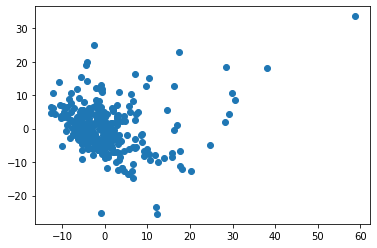

In [355]:
plt.scatter(components[ : , 0], components[ : , 1])

#### Producing a more informative visualization

So far, that's just a glob of dots. What can we learn from it?

To start with, it would be helpful if we could color the dots by genre. We can't simply assign a color to each genre, because genres in this dataset are not exclusive. Each movie can have a number of different genre tags.

But we could, for instance, visualize two genres at once, giving one color to genre A, one to genre B, and a third color to the films with both genres.

By the way, what genres do we have in this subset?

In [257]:
genreset = set()

for idx, row in moviesubset.iterrows():
    genres = literal_eval(row.genres)
    for g in genres:
        genreset.add(g)
        
genreset

{'action',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'romance',
 'sci-fi',
 'sport',
 'thriller',
 'war',
 'western'}

Let's create a function that we can use to color the points.

In [258]:
def genre2color(row, orangegenre, bluegenre):
    color = 'other'
    
    genres = literal_eval(row['genres'])  # this turns the "genres" string into an actual Python list
                        # e.g. "['comedy', 'romance']" becomes ['comedy', 'romance']
    
    genrecount = 0
    
    if orangegenre in genres:
        color = orangegenre
        genrecount += 1
    if bluegenre in genres:
        color = bluegenre
        genrecount += 1
        
    if genrecount > 1:
        color = 'both'
    
    return color


Coloring the dots is a good start on making this readable, but ... it would be a little nicer if we could label some of the films.

Unfortunately, we have too many dots to label them all. It would be nice if we could select some widely spaced examples of the genres we're coloring.

That could be done manually, but I've written the function below to do it automatically. You should basically ignore the details here, because all this function is doing is selecting a list of line numbers that correspond to widely spaced points. If you needed to do choose dots to label yourself, you could always do it manually; that would be much easier.

In [309]:
def get_outliers(plotframe):
    
    # This is more complex than it really needs to be.
    # I'm using a complex strategy to make sure the
    # outliers we label are evenly distributed and not so
    # close to each other that the labels overlap.
    
    outliers = []
    skip = set()
    
    meanx = np.mean(plotframe['x'])
    meany = np.mean(plotframe['y'])

    for points_labeled in range(20):

        distances = []

        for linenum in range(plotframe.shape[0]):
            if linenum in outliers or linenum in skip or plotframe.color[linenum] == 'other':
                continue
            else:
                euclidnorm = math.sqrt((plotframe.x[linenum] - meanx) ** 2 + (plotframe.y[linenum] - meany) **2)
                distances.append((euclidnorm, linenum))

        distances.sort()

        chosen = distances[-1][1]
        tooclose = False

        for already_have in outliers:
            verticaldist = abs(plotframe.y[already_have] - plotframe.y[chosen])
            if verticaldist < 0.015:
                tooclose = True
                skip.add(chosen)

        if not tooclose:        
            outliers.append(chosen)

        meanx = np.mean([meanx, np.mean(plotframe.loc[outliers, 'x'])])
        meany = np.mean([meany, np.mean(plotframe.loc[outliers, 'y'])])
    
    return outliers

Now we choose genres to color, assign specific colors to them, and label the list of points we're calling "outliers."

If you want to change the colors, here's [a list of color names in python.](https://matplotlib.org/stable/gallery/color/named_colors.html)

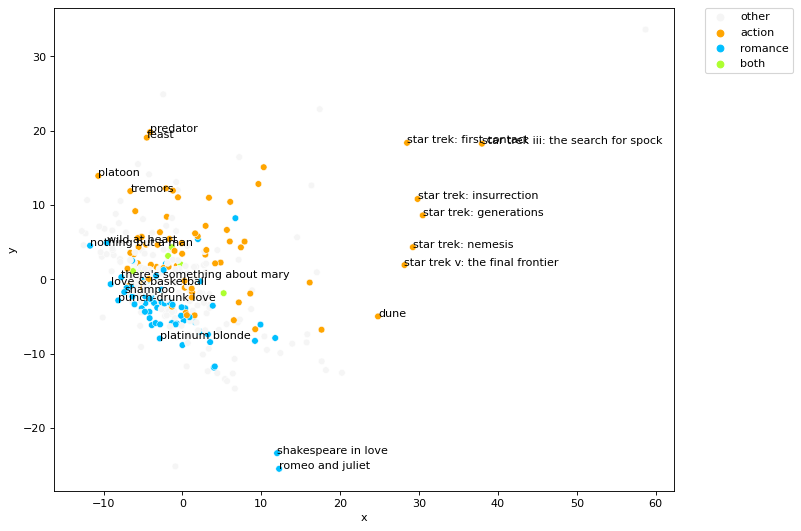

In [356]:
colorseq = []

orangegenre = 'action'
bluegenre = 'romance'

for idx, row in moviesubset.iterrows():
    thiscolor = genre2color(row, orangegenre, bluegenre)
    colorseq.append(thiscolor)

plotframe = pd.DataFrame({'x': components[ : , 0], 'y': components[ : , 1],
                         'color': colorseq})
colordict = {'other': 'whitesmoke', orangegenre: 'orange',
            'both': 'greenyellow', bluegenre: 'deepskyblue'}

plt.figure(figsize=(10, 8), dpi=80)
theplot = sns.scatterplot(data = plotframe, x = 'x', y = 'y', hue = 'color',
               palette = colordict)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

outliers = get_outliers(plotframe)  # this just gets a list of

for line in outliers:
     theplot.text(plotframe.x[line]+0.0005, plotframe.y[line] + .0005, 
     moviesubset.index[line], horizontalalignment='left', 
     size='medium', color='black', weight='normal')

plt.show()

There could be some random variation between our plots. But I suspect many of us will see *Star Trek* movies on the right-hand side of this--and most of the romances in the lower left corner.

This is *unsupervised*; the analysis doesn't know which movies belong to which human-perceived genre. It's just looking for a viewing angle that makes things spread out as much as possible. Since action movies are pretty different from romances, that happens to be an angle of view that makes those two genres relatively distinct.

#### EXPLORATION

Try the same thing with different pairs of genres--"comedy" and "romance," for instance, or "sci-fi" and "horror"--to see whether you get different patterns. You can also go back to the cell where we "selected a set of movies," and change the random seed or the number of movies, to see if that changes the result.

After 5 minutes of self-directed exploration, we'll convene in small groups, and each group will select a result to show.

#### Understanding the axes of the plot

If you want to understand the axes of PCA it *is* possible to extract an explanation. You can create a matrix ...

In [261]:
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=normed_subset.columns)
loadings.iloc[0:4, ]

,PC1,PC2
the,0.059181,0.022344
to,0.024157,-0.018684
what,-0.028956,0.024456
you,-0.048060,-0.022503


... and then sort each column to figure out which of the original variables play a big role in defining the ends of the axis. E.g., here's the right-hand (positive) side of the X axis. In many of the plots I've produced, this is a pole that attracts a lot of science fiction, and especially Star Trek movies.

In [262]:
loadings['PC1'].sort_values()[-20: ]

data          0.060593
will          0.060733
is            0.060830
intended      0.061371
earth         0.062415
recommend     0.062521
planet        0.062571
cannot        0.063278
command       0.063470
destroying    0.063820
object        0.063913
scan          0.065254
carbon        0.066986
units         0.068508
vessel        0.068822
logic         0.069561
may           0.070190
as            0.070427
has           0.070668
captain       0.078178
Name: PC1, dtype: float64

This is the lower (negative) side of the Y axis:

In [263]:
loadings['PC2'].sort_values()[0: 20]

love        -0.060448
very        -0.058704
dear        -0.058479
perhaps     -0.052826
shall       -0.051928
my          -0.051794
and         -0.047365
lady        -0.046269
nor         -0.045984
marriage    -0.045813
mother      -0.045489
ill         -0.045141
gentleman   -0.044099
wonderful   -0.043326
your        -0.043272
will        -0.041169
not         -0.040963
speak       -0.040506
young       -0.040221
woman       -0.040033
Name: PC2, dtype: float64

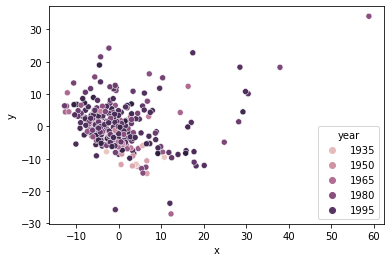

In [285]:
plotframe['year'] = moviesubset['year'].values

theplot = sns.scatterplot(data = plotframe, x = 'x', y = 'y', hue = 'year')

<AxesSubplot:xlabel='year', ylabel='Count'>

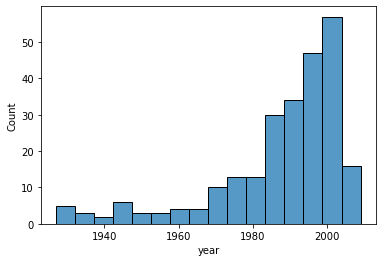

In [265]:
sns.histplot(plotframe.year)

### Clustering

We've been using human-assigned labels to identify clusters of works, and then visualizing them in an abstract space that we inferred algorithmically using PCA.

In *theory* we could also use an algorithm to infer clusters of works. But I have to say, clustering algorithms are more something that gets *taught* in data science courses than something that really works well, in practice, on real cultural data. If your data is relatively simple and has sharp boundaries between species of iris, or species of penguin, clustering may work on it. Actual cultural data tends to have blurry boundaries and lots of dimensions, and clustering is not especially powerful in that situation.

For an overview of different clustering algorithms available in scikit-learn you can [consult the documentation.](https://scikit-learn.org/stable/modules/clustering.html)

In [266]:
from sklearn.cluster import KMeans, AgglomerativeClustering

In terms of programming, clustering is very simple. We create a clustering instance, and then fit it to our data.

In [357]:
kmeans = KMeans(n_clusters=5, random_state=10).fit(normed_subset)

In [358]:
pd.Series(kmeans.labels_).value_counts()

2    191
1    126
0      1
3      1
4      1
dtype: int64

In [330]:
agglom = AgglomerativeClustering(n_clusters = 5).fit(subset_freqs)

In [331]:
pd.Series(agglom.labels_).value_counts()

2    175
1     77
0     66
3      1
4      1
dtype: int64

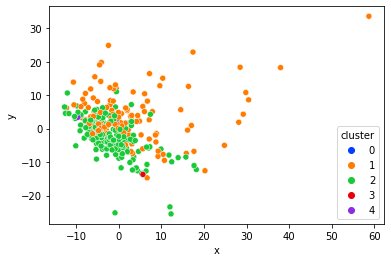

In [359]:
plotframe['cluster'] = kmeans.labels_
theplot = sns.scatterplot(data = plotframe, x = 'x', y = 'y', hue = 'cluster', palette = 'bright')

In [360]:
moviesubset['cluster'] = kmeans.labels_
moviesubset.loc[moviesubset.cluster == 1, :]

,mid,wordcount,year,genres,comedy,thriller,drama,romance,lines,action,cluster
mname,,,,,,,,,,,
a nightmare on elm street 4: the dream master,m7,649,1988,"['fantasy', 'horror', 'thriller']",False,True,False,False,Figure it out?!?! I'll be insane before I fig...,False,1
the deer hunter,m320,2674,1978,"['drama', 'war']",False,False,True,False,Hey! Fuckin' A! Just... just like a hot shit.....,False,1
the godfather: part ii,m369,7225,1974,"['crime', 'drama', 'thriller']",False,True,True,False,"Mike, what can I do, she's a hysterical woman....",False,1
the atomic submarine,m9,1335,1959,"['sci-fi', 'thriller']",False,True,False,False,I wouldn't worry. So long as we have boats li...,False,1
jurassic park,m411,4596,1993,"['action', 'adventure', 'family', 'sci-fi', 'a...",False,False,False,False,How long will this take? / How would we cut of...,True,1
...,...,...,...,...,...,...,...,...,...,...,...
panther,m156,2993,1995,['drama'],False,False,True,False,Just hold on a god damn minute. I... / What th...,False,1
an american werewolf in paris,m241,3473,1997,"['horror', 'romance', 'thriller', 'comedy']",True,True,False,True,"Ha-ha! / Hey, you can't kick me! You're an app...",False,1
kundun,m417,1791,1997,"['biography', 'drama', 'history', 'war']",False,False,True,False,We are now accused of aiding the rebels. The C...,False,1


## Exploring words in movie space

If we *transpose* our matrix, so rows become columns and columns rows, we can apply PCA in order to plot *words* in movie-space.


In [64]:
wordinmovspace = moviefreqs.transpose()

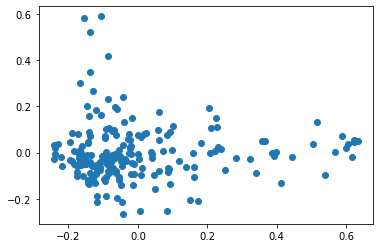

In [368]:
wordsinmovspace = moviefreqs.transpose().sample(200, random_state = 50)
wordvectorlengths = np.linalg.norm(wordsinmovspace, ord = 2, axis = 1)
wordsinmovspace = wordsinmovspace.divide(wordvectorlengths, axis = 'rows')

wordcounttotals = moviecounts.loc[ : , wordsinmovspace.index].sum(axis = 'rows')

pca = PCA(n_components = 2)
components = pca.fit_transform(wordsinmovspace)
plt.scatter(components[ : , 0], components[ : , 1])

In [369]:
wordsinmovspace.head()

,10 things i hate about you,1492: conquest of paradise,affliction,innerspace,the insider,intolerable cruelty,it happened one night,jfk,jackie brown,jacob's ladder,...,his girl friday,hope and glory,house of 1000 corpses,human nature,the hustler,i am legend,invaders from mars,independence day,indiana jones and the last crusade,indiana jones and the temple of doom
mid,0.000000,0.000000,0.000000,0.000000,0.164399,0.000000,0.000000,0.000000,0.000000,0.164399,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.164399,0.000000
dime,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.240772,0.000000,0.000000,0.000000,0.120386,0.0,0.000000,0.000000,0.000000,0.000000
didn,0.034078,0.007573,0.041651,0.034078,0.034078,0.030292,0.094662,0.079516,0.159032,0.064370,...,0.068156,0.022719,0.026505,0.018932,0.049224,0.0,0.003786,0.022719,0.030292,0.011359
ape,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.802955,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
connections,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000


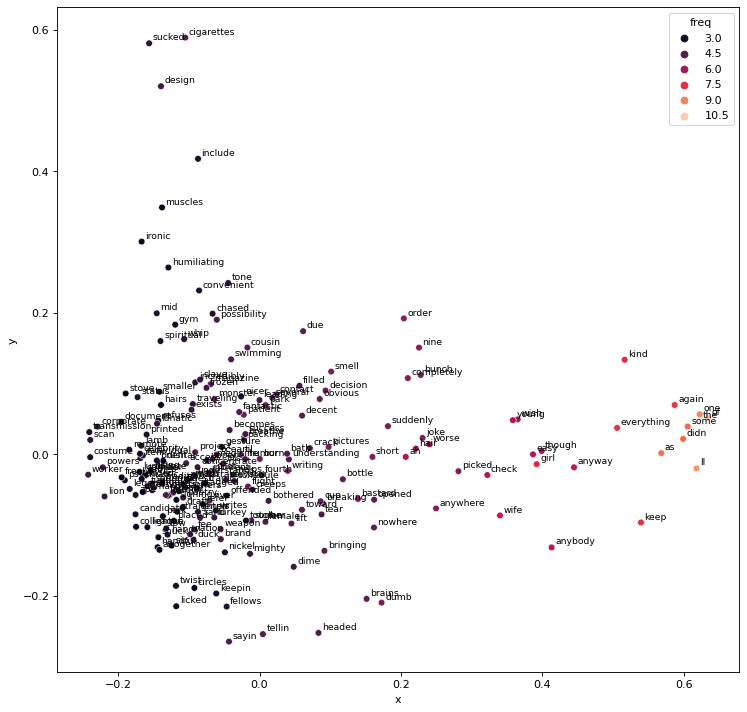

In [370]:
plotframe = pd.DataFrame({'x': components[ : , 0], 'y': components[ : , 1],
                         'labels': wordsinmovspace.index, 'freq': np.log(wordcounttotals)})

plt.figure(figsize=(11, 11), dpi=80)
theplot = sns.scatterplot(data = plotframe, x = 'x', y = 'y', hue = 'freq',
                         palette = 'rocket')

for line in plotframe.index:
     theplot.text(plotframe.x[line]+ 0.005, plotframe.y[line] + .005, 
     plotframe.labels[line], horizontalalignment='left', 
     size='small', color='black', weight='medium')

plt.show()